In [1]:
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filtered_best_ligand_ic50 = pd.read_csv('data/filtered_best_ligand_ic50.csv')
unique_smiles_df = pd.DataFrame({'Ligand SMILES': filtered_best_ligand_ic50['Ligand SMILES_x'].unique()})
embeddings = pd.read_csv('data/all_graph_embeddings.csv')

Define the labels: UMAP followed by KMeans clustering

/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


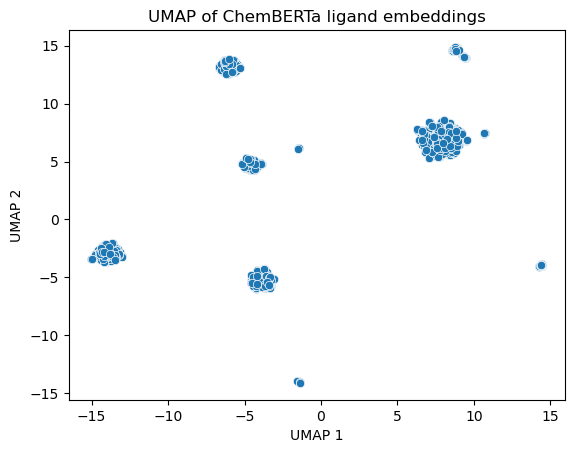

In [3]:
# Normalize the features
X_normalized = StandardScaler().fit_transform(embeddings)

# Apply UMAP
n = 3
umap_model = umap.UMAP(n_components=n,random_state=42)
X_transformed_UMAP = umap_model.fit_transform(X_normalized)

# Create dataframe for UMAP values
umap_df = pd.DataFrame(X_transformed_UMAP, columns=[f'UMAP {i}' for i in range(1, n+1)])

# Merge it with the SMILES dataframe
merged_umap_df = pd.concat([unique_smiles_df, umap_df], axis=1)

sns.scatterplot(data=merged_umap_df, x='UMAP 1', y='UMAP 2', legend=False)
plt.title('UMAP of ChemBERTa ligand embeddings');

Text(0.5, 1.0, 'k-means clustering of UMAPed ChemBERTa representations')

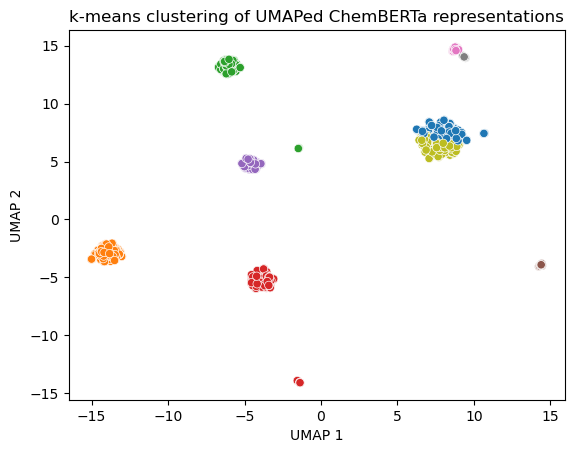

In [4]:
kmeans_labels_UMAP = KMeans(n_clusters=9, random_state=42).fit_predict(X_transformed_UMAP)
merged_umap_df = pd.concat([merged_umap_df, pd.DataFrame({'class':kmeans_labels_UMAP})], axis=1)
palette = sns.color_palette('tab10', n_colors=9)
sns.scatterplot(data=merged_umap_df, x='UMAP 1', y='UMAP 2', hue='class', palette=palette, legend=False)
plt.title('k-means clustering of UMAPed ChemBERTa representations')

In [5]:
filtered_best_ligand_ic50.rename(columns={'Ligand SMILES_x': 'Ligand SMILES'}, inplace=True)

In [6]:
protein_ligand_matched = pd.merge(filtered_best_ligand_ic50, merged_umap_df, on='Ligand SMILES', how='inner')

In [7]:
protein_ligand_matched['ESM2 Embedding'] = protein_ligand_matched['ESM2 Embedding'].apply(lambda x: eval("torch." + x))

k-NN on the UMAP of protein embeddings

/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


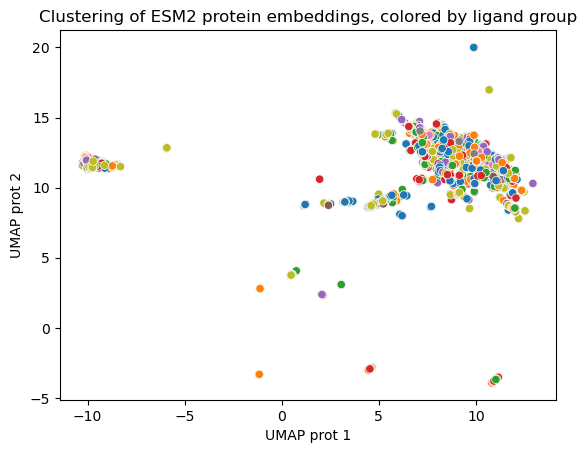

In [8]:
X_prot = np.array([np.squeeze(x) for x in protein_ligand_matched['ESM2 Embedding']])
X_prot_normalized = StandardScaler().fit_transform(X_prot)
n = 3 
umap_model = umap.UMAP(n_components=n, random_state=17)
X_prot_transformed_UMAP = umap_model.fit_transform(X_prot_normalized)

umap_prot_df = pd.DataFrame(X_prot_transformed_UMAP, columns=[f'UMAP prot {i}' for i in range(1, n+1)])
umap_prot_df.set_index(protein_ligand_matched.index, inplace=True)
protein_ligand_matched = pd.concat([protein_ligand_matched, umap_prot_df], axis=1)

sns.scatterplot(data=protein_ligand_matched, x='UMAP prot 1', y='UMAP prot 2', hue='class', legend=False, palette=palette)
plt.title('Clustering of ESM2 protein embeddings, colored by ligand group');

**Let us train and evaluate other classifier types, but directly on protein embeddings (not their UMAP).**

The dataset is not balanced w.r.t. ligand classes. Hence, we should evaluate our classifier based on the *macro*-average of the performance metrics, i.e. weight equally the different ligand classes.

In [34]:
from sklearn.metrics import balanced_accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


X = X_prot
y = protein_ligand_matched['class']

# k-NN: add cross-validation on the number of neighbors
knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X, y)
y_pred = knn_clf.predict(X)
print(f'k-NN: balanced accuracy of {balanced_accuracy_score(y, y_pred):.4f}.\n-----')

# SVM: with or without kernel trick?
svm_clf = SVC(random_state=17)
svm_clf.fit(X, y)
y_pred = svm_clf.predict(X)
print(f'SVM: balanced accuracy of {balanced_accuracy_score(y, y_pred):.4f}.\n-----')

# Multinomial logistic regression, loss: choose between OvR and cross-entropy
ll_clf = LogisticRegression(multi_class='multinomial', random_state=17)
ll_clf.fit(X, y)
y_pred = ll_clf.predict(X)
print(f'Multinomial logistic regression: balanced accuracy of {balanced_accuracy_score(y, y_pred):.4f}.\n-----')

# Multilayer perceptron
mlp_clf = MLPClassifier(random_state=17, hidden_layer_sizes=(100, )) # single hidden layer with 100 neurons
mlp_clf.fit(X, y)
y_pred = mlp_clf.predict(X)
print(f'MLP with 1 hidden layer: balanced accuracy of {balanced_accuracy_score(y, y_pred):.4f}.\n-----')

k-NN: balanced accuracy of 0.2548.
-----
SVM: balanced accuracy of 0.1287.
-----


/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Multinomial logistic regression: balanced accuracy of 0.1903.
-----
MLP with 1 hidden layer: balanced accuracy of 0.5020.
-----


/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
mlp3_clf = MLPClassifier(random_state=17, hidden_layer_sizes=(100, 100, 100)) # three hidden layers with 100 neurons
mlp3_clf.fit(X, y)
y_pred = mlp3_clf.predict(X)
print(f'MLP with 3 hidden layers: balanced accuracy of {balanced_accuracy_score(y, y_pred):.4f}.\n-----')

MLP with 3 hidden layers: balanced accuracy of 0.8326.
-----


/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
